In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
df = pd.read_csv('/content/processed_train_FD001.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (20631, 13)


,engine_id,time_in_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,-1.565170,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.603816,-0.781710,1.348493,1.194427,191
1,1,-1.550652,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.275852,-0.781710,1.016528,1.236922,190
2,1,-1.536134,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-0.649144,-2.073094,0.739891,0.503423,189
3,1,-1.521616,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.971665,-0.781710,0.352598,0.777792,188
4,1,-1.507098,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.339845,-0.136018,0.463253,1.059552,187


will_work_n_cycles
1    15531
0     5100
Name: count, dtype: int64


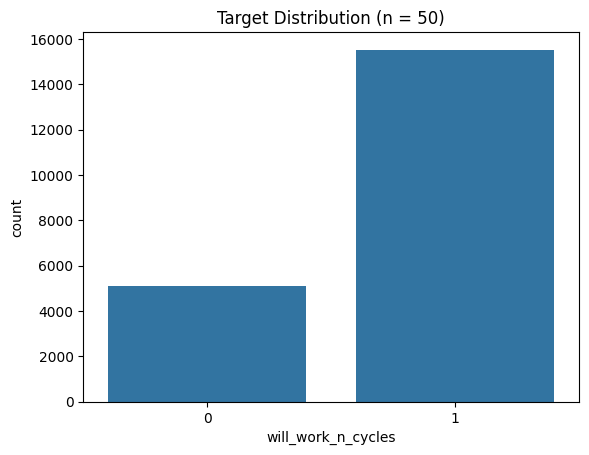

In [4]:
# Create binary target column (RUL > 50 -> 1 else 0)
n = 50
df['will_work_n_cycles'] = np.where(df['RUL'] > n, 1, 0)

# Drop the RUL column
df.drop(columns=['RUL'], inplace=True)
# Check new target distribution
print(df['will_work_n_cycles'].value_counts())
sns.countplot(x='will_work_n_cycles', data=df)
plt.title("Target Distribution (n = 50)")
plt.show()


In [5]:
df.head()

,engine_id,time_in_cycles,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_15,sensor_17,sensor_20,sensor_21,will_work_n_cycles
0,1,-1.565170,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.603816,-0.781710,1.348493,1.194427,1
1,1,-1.550652,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.275852,-0.781710,1.016528,1.236922,1
2,1,-1.536134,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-0.649144,-2.073094,0.739891,0.503423,1
3,1,-1.521616,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.971665,-0.781710,0.352598,0.777792,1
4,1,-1.507098,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.339845,-0.136018,0.463253,1.059552,1


In [6]:
# Split by engine IDs (to avoid data leakage)
engines = df['engine_id'].unique()

train_engines, test_engines = train_test_split(engines, test_size=0.2, random_state=42)

train_df = df[df['engine_id'].isin(train_engines)]
test_df  = df[df['engine_id'].isin(test_engines)]

# Define features and target
X_train = train_df.iloc[:, 1:-1]
y_train = train_df.iloc[:, -1]
X_test  = test_df.iloc[:, 1:-1]
y_test  = test_df.iloc[:, -1]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (16561, 11) Test shape: (4070, 11)


In [7]:
# Initialize models

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [8]:
# Train and evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','AUC'])
results_df.sort_values(by='F1', ascending=False).reset_index(drop=True)


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.933907,0.951608,0.960656,0.956110,0.978131
1,Random Forest,0.931941,0.945104,0.965246,0.955069,0.980660
2,Gradient Boosting,0.930221,0.945841,0.961967,0.953836,0.980999
3,XGBoost,0.922113,0.942950,0.953770,0.948329,0.977346


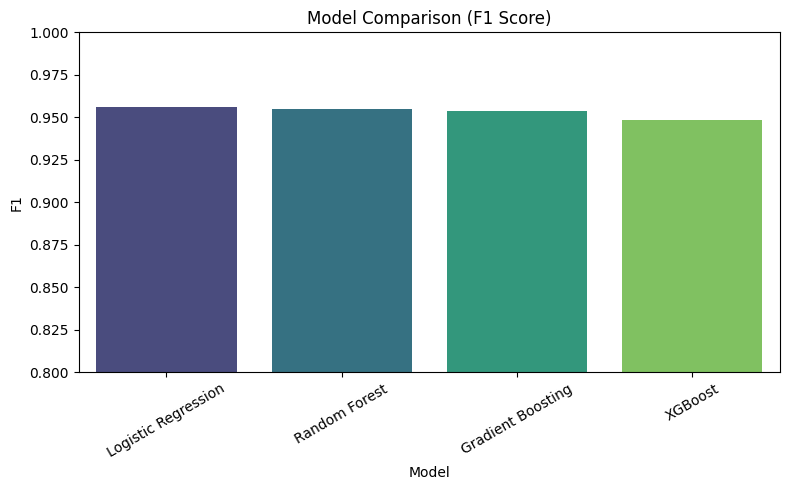

In [9]:
# Model comparision

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='F1', data=results_df, palette='viridis')
plt.title('Model Comparison (F1 Score)')
plt.ylim(0.8, 1.0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



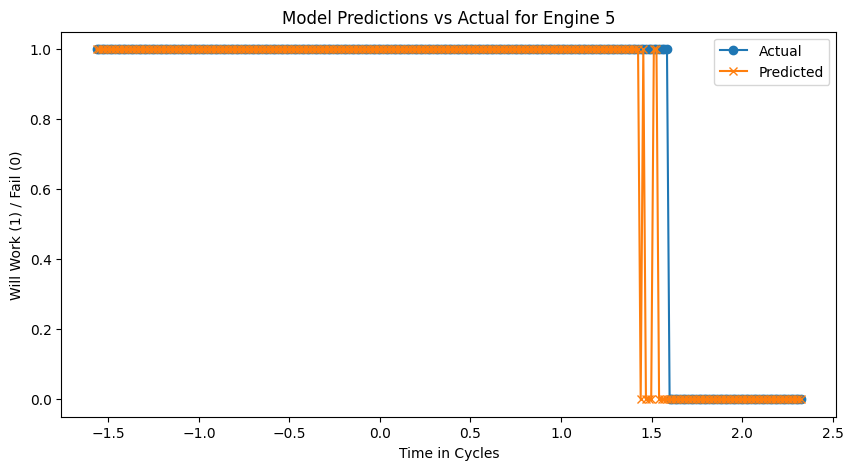

In [12]:
# Results visualized on sample engine
sample_engine = np.random.choice(test_engines)
engine_df = test_df[test_df['engine_id'] == sample_engine].copy()

best_model_name = results_df.sort_values('F1', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]

feature_cols = X_train.columns

engine_df['pred'] = best_model.predict(engine_df[feature_cols])
engine_df['prob'] = best_model.predict_proba(engine_df[feature_cols])[:,1]

plt.figure(figsize=(10,5))
plt.plot(engine_df['time_in_cycles'], engine_df['will_work_n_cycles'], label='Actual', marker='o')
plt.plot(engine_df['time_in_cycles'], engine_df['pred'], label='Predicted', marker='x')
plt.title(f'Model Predictions vs Actual for Engine {sample_engine}')
plt.xlabel('Time in Cycles')
plt.ylabel('Will Work (1) / Fail (0)')
plt.legend()
plt.show()


In [11]:
df.columns

Index(['engine_id', 'time_in_cycles', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_15', 'sensor_17',
       'sensor_20', 'sensor_21', 'will_work_n_cycles'],
      dtype='object')